In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
plt.rcParams["figure.autolayout"] = True

In [2]:
import torch
from torch import nn, optim
from utils import Legendre_Polynomials, Finite_Elements
import torch.nn.functional as F

## Defining the parameters of the equation

In [3]:
# f = lambda x: x ** -.25  # Source function
f = lambda x: 1  # Source function
k = 3. * (np.pi / 2)  # frequency
a, b = -1., +1.  # Domain
ga, gb = 0., 1.  # Values at the boundaries

In [4]:
# i = 0

# x = torch.tensor([[-1], [0], [1]]).float().requires_grad_()

# # for n, p in model.named_parameters():
# #     print(f'{n}: {p}')

# z = x @ model.lins[0].weight.T + model.lins[0].bias
# cw = model.lins[1].weight[i].view(-1) * model.lins[0].weight.view(-1)

# j = 0
# cw[torch.where(z[j] > 0)].sum()

# model.deriv(2, x)

# x = torch.tensor([[0], [0], [0]]).float().requires_grad_()

# testfunctions = Finite_Elements(20 - 1, a, b)()
# v_k = testfunctions[10]

# model.res(v_k, i=2)
# v_k(model.weights)
# type(model.weights
# torch.heaviside(x, torch.tensor([1.]))


## Training the neural network

In [5]:
from solvers import VPINN_HelmholtzImpedance

width = 20
depth = 1
activation = F.relu
testfuncs = 20
penalty = None

cuda = False
epochs = 30000
lr = 1e-03
momentum = .2
seed = None
dropout_probs = None

model = VPINN_HelmholtzImpedance(f=f, k=k, a=a, b=b, ga=ga, gb=gb,
                                layers=[1] + [width for _ in range(depth)] + [2],
                                activation=activation,
                                dropout_probs=dropout_probs,
                                penalty=penalty,
                                N_quad=100,
                                seed=seed,
                                cuda=cuda,
                                )

# testfunctions = Legendre_Polynomials(testfuncs - 1, a, b)()
testfunctions = Finite_Elements(testfuncs - 1, a, b, dtype=torch.Tensor)()
if cuda:
  model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=lr)
model.train_(testfunctions, epochs, optimizer)

/home/sepeehr/anaconda3/envs/mcss/lib/python3.9/site-packages/scipy/special/orthogonal.py:139: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))


Epoch 000000 / 30000: loss = 4.13e+04
Epoch 000100 / 30000: loss = 3.01e+04
Epoch 000200 / 30000: loss = 2.15e+04
Epoch 000300 / 30000: loss = 1.50e+04
Epoch 000400 / 30000: loss = 1.02e+04
Epoch 000500 / 30000: loss = 6.81e+03
Epoch 000600 / 30000: loss = 4.39e+03
Epoch 000700 / 30000: loss = 2.72e+03
Epoch 000800 / 30000: loss = 1.62e+03
Epoch 000900 / 30000: loss = 9.25e+02
Epoch 001000 / 30000: loss = 5.01e+02
Epoch 001100 / 30000: loss = 2.57e+02
Epoch 001200 / 30000: loss = 1.25e+02
Epoch 001300 / 30000: loss = 5.74e+01
Epoch 001400 / 30000: loss = 2.48e+01
Epoch 001500 / 30000: loss = 1.01e+01
Epoch 001600 / 30000: loss = 3.87e+00
Epoch 001700 / 30000: loss = 1.41e+00
Epoch 001800 / 30000: loss = 5.05e-01
Epoch 001900 / 30000: loss = 1.94e-01
Epoch 002000 / 30000: loss = 9.47e-02
Epoch 002100 / 30000: loss = 6.55e-02
Epoch 002200 / 30000: loss = 5.76e-02
Epoch 002300 / 30000: loss = 5.56e-02
Epoch 002400 / 30000: loss = 5.51e-02
Epoch 002500 / 30000: loss = 5.50e-02
Epoch 002600

KeyboardInterrupt: 

### More epochs with differenet learning rate

In [12]:
lr = 1e-03
epochs = 5000

optimizer = optim.Adam(model.parameters(), lr=lr)
model.train_(testfunctions, epochs, optimizer)

Epoch 000000 / 5000: loss = 4.32e-02


## Evaluating the results

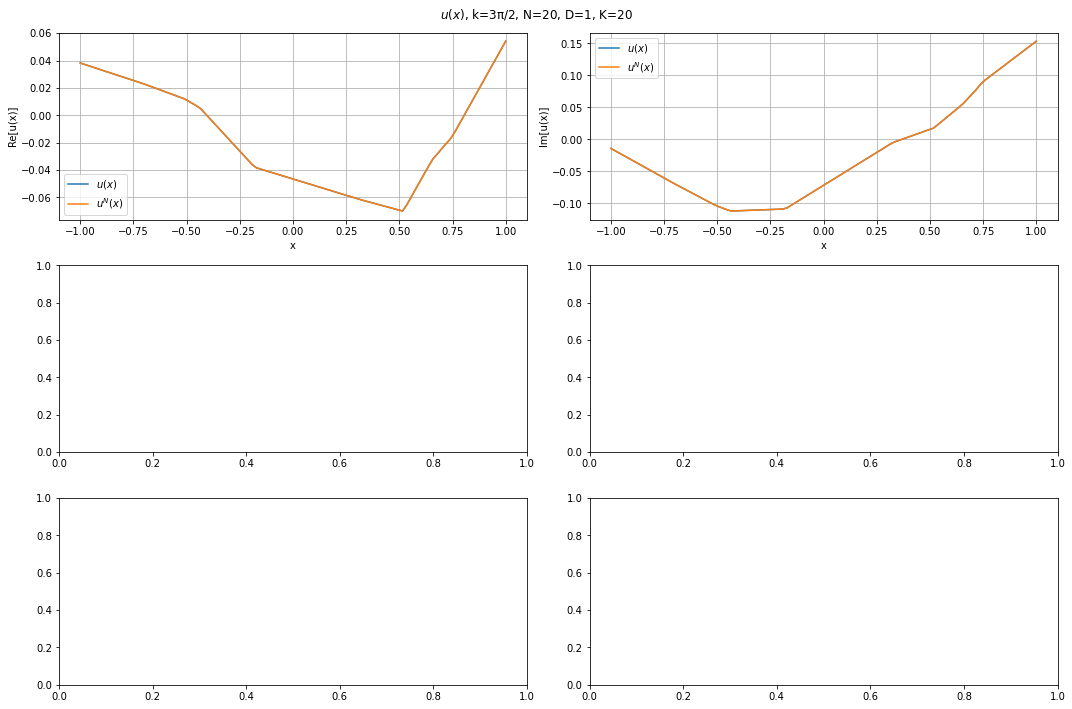

In [ ]:
xpts = torch.linspace(a, b, 100).float().view(-1, 1)

model.eval()
upts_re, upts_im = model.deriv(0, xpts)  # FIXME: Should be exact solution
rpts_re, rpts_im = model.deriv(0, xpts)
with torch.no_grad():
    xpts = xpts.numpy()
    upts_re = upts_re.numpy()
    upts_im = upts_im.numpy()
    rpts_re = rpts_re.numpy()
    rpts_im = rpts_im.numpy()

plt.rcParams['figure.figsize'] = [15, 10]
fig, axs = plt.subplots(3, 2)
fig.tight_layout(pad=4.0)
fig.suptitle(f'$u(x)$, k={round(model.k.item() / (np.pi / 2))}π/2, N={width}, D={depth}, K={testfuncs}')

axs[0, 0].plot(xpts, upts_re, label='$u(x)$')
axs[0, 0].plot(xpts, rpts_re, label='$u^N(x)$')
axs[0, 0].set(xlabel='x', ylabel='Re[u(x)]')
axs[0, 0].legend()
axs[0, 0].grid()
axs[0, 1].plot(xpts, upts_im, label='$u(x)$')
axs[0, 1].plot(xpts, rpts_im, label='$u^N(x)$')
axs[0, 1].set(xlabel='x', ylabel='Im[u(x)]')
axs[0, 1].legend()
axs[0, 1].grid()

# axs[1, 0].errorbar(xpts, upts.real, yerr=upts.real - rpts.real, ecolor='black', label='$u(x)$')
# axs[1, 0].set(xlabel='x', ylabel='Re[u(x)]')
# axs[1, 0].legend()
# axs[1, 0].grid()
# axs[1, 1].errorbar(xpts, upts.imag, yerr=upts.imag - rpts.imag, ecolor='black', label='$u(x)$')
# axs[1, 1].set(xlabel='x', ylabel='Im[u(x)]')
# axs[1, 1].legend()
# axs[1, 1].grid()

# axs[2, 0].plot(xpts, upts.real - rpts.real)
# axs[2, 0].set(xlabel='x', ylabel='$Re[u(x)-u^N(x)]$')
# axs[2, 0].grid()
# axs[2, 1].plot(xpts, upts.imag - rpts.imag)
# axs[2, 1].set(xlabel='x', ylabel='$Im[u(x)-u^N(x)]$')
# axs[2, 1].grid()

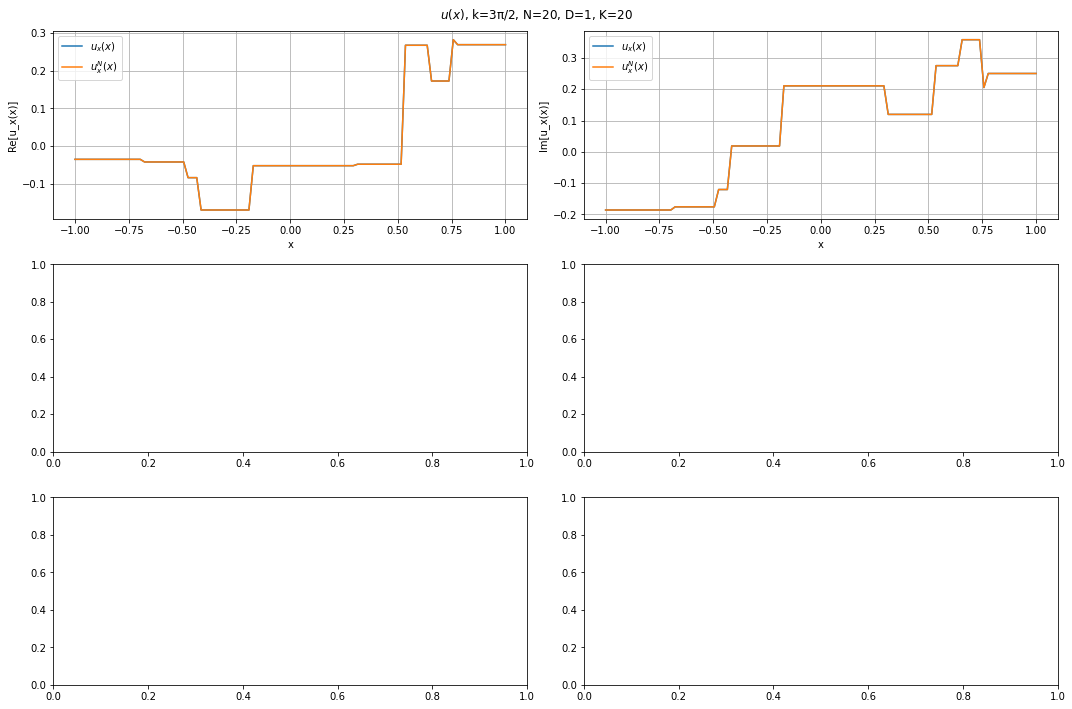

In [ ]:
xpts = torch.linspace(a, b, 100).float().view(-1, 1).requires_grad_()

model.eval()
upts_re, upts_im = model.deriv(1, xpts)  # FIXME: Should be exact solution
rpts_re, rpts_im = model.deriv(1, xpts)
with torch.no_grad():
    xpts = xpts.numpy()
    upts_re = upts_re.numpy()
    upts_im = upts_im.numpy()
    rpts_re = rpts_re.numpy()
    rpts_im = rpts_im.numpy()

plt.rcParams['figure.figsize'] = [15, 10]
fig, axs = plt.subplots(3, 2)
fig.tight_layout(pad=4.0)
fig.suptitle(f'$u(x)$, k={round(model.k.item() / (np.pi / 2))}π/2, N={width}, D={depth}, K={testfuncs}')

axs[0, 0].plot(xpts, upts_re, label='$u_x(x)$')
axs[0, 0].plot(xpts, rpts_re, label='$u^N_x(x)$')
axs[0, 0].set(xlabel='x', ylabel='Re[u_x(x)]')
axs[0, 0].legend()
axs[0, 0].grid()
axs[0, 1].plot(xpts, upts_im, label='$u_x(x)$')
axs[0, 1].plot(xpts, rpts_im, label='$u^N_x(x)$')
axs[0, 1].set(xlabel='x', ylabel='Im[u_x(x)]')
axs[0, 1].legend()
axs[0, 1].grid()

# axs[1, 0].errorbar(xpts, upts.real, yerr=upts.real - rpts.real, ecolor='black', label='$u_x(x)$')
# axs[1, 0].set(xlabel='x', ylabel='Re[u_x(x)]')
# axs[1, 0].legend()
# axs[1, 0].grid()
# axs[1, 1].errorbar(xpts, upts.imag, yerr=upts.imag - rpts.imag, ecolor='black', label='$u_x(x)$')
# axs[1, 1].set(xlabel='x', ylabel='Im[u_x(x)]')
# axs[1, 1].legend()
# axs[1, 1].grid()

# axs[2, 0].plot(xpts, upts.real - rpts.real)
# axs[2, 0].set(xlabel='x', ylabel='$Re[u_x(x)-u^N_x(x)]$')
# axs[2, 0].grid()
# axs[2, 1].plot(xpts, upts.imag - rpts.imag)
# axs[2, 1].set(xlabel='x', ylabel='$Im[u_x(x)-u^N_x(x)]$')
# axs[2, 1].grid()